In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import torch.nn.functional as F

In [13]:
data=pd.read_csv('winequality-red.csv',sep=';')
data=data[data['total sulfur dioxide']<200]
data=data.apply(stats.zscore)
X=data.drop('residual sugar',axis=1)
y=data['residual sugar']
y=y.to_frame()



In [14]:
Xt=torch.tensor(X.values).float()
yt=torch.tensor(y.values).float()
print(Xt.shape)
print(yt.shape)

torch.Size([1597, 11])
torch.Size([1597, 1])


Text(0, 0.5, 'sugar(norm)')

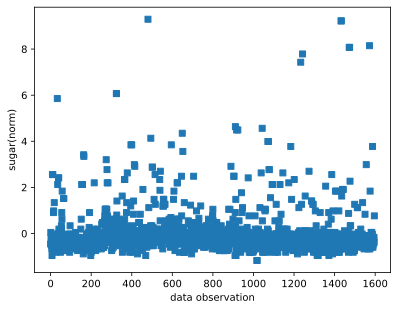

In [17]:
plt.plot(yt,'s')
plt.xlabel('data observation')
plt.ylabel('sugar(norm)')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
Xt, yt, test_size=0.3, random_state=42)
train_data=TensorDataset(X_train,y_train)
test_data=TensorDataset(X_test,y_test)

train_loader=DataLoader(train_data,batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [43]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input=nn.Linear(11,16)
        
        self.fc1=nn.Linear(16,32)
        
        self.fc2=nn.Linear(32,16)
        
        
        self.output=nn.Linear(16,1)
        
         
    def forward(self,x):
        
        
        x=F.relu(self.input(x))
        
        
        
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
            
        return self.output(x)
            
         

In [44]:
numepochs=1000
def trainModel():
    lossfun=nn.MSELoss()
    optimizer=torch.optim.SGD(winenet.parameters(),lr=0.01)
    trainLoss=[]
    testLoss=[]

    for epochi in range(numepochs):
        winenet.train()
        
        batchLoss=[]
        for X,y in train_loader:
            yHat=winenet(X)
            loss=lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchLoss.append(loss.item())
            
        trainLoss.append(np.mean(batchLoss))
        
        
        X,y=next(iter(test_loader))
        winenet.eval()
        with torch.no_grad():
           
            
        
            testLoss.append(lossfun(winenet(X),y).item())
        
    return trainLoss,testLoss
             

In [48]:
winenet=ANNwine()
trainLoss,testLoss=trainModel()

In [49]:

yHattrain=winenet(X_train)
yHattest=winenet(X_test)

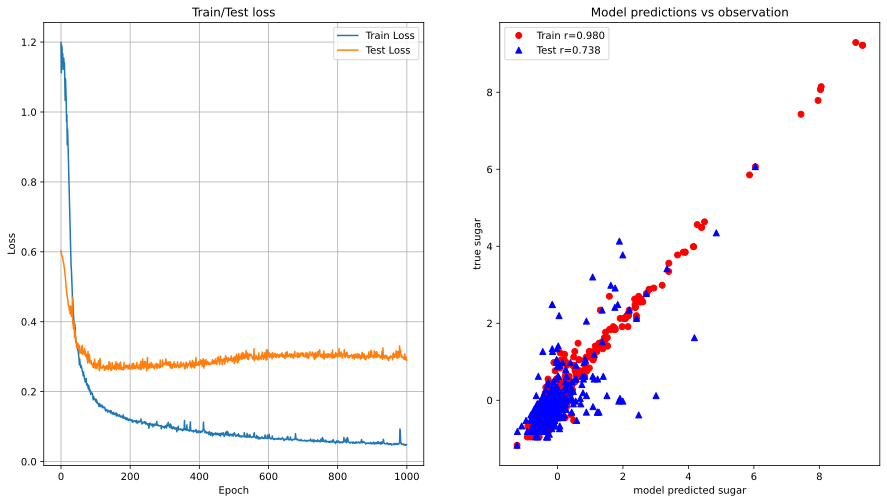

In [50]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
ax[0].plot(trainLoss,label='Train Loss')
ax[0].plot(testLoss,label='Test Loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()
ax[1].plot(yHattrain.detach(),y_train,'ro')
ax[1].plot(yHattest.detach(),y_test,'b^')

ax[1].set_title('Model predictions vs observation')
ax[1].set_xlabel('model predicted sugar')
ax[1].set_ylabel('true sugar')

corrtrain=np.corrcoef(yHattrain.detach().T,y_train.T)[1,0]
corrtest=np.corrcoef(yHattest.detach().T,y_test.T)[1,0]
ax[1].legend([f'Train r={corrtrain:.3f}',f'Test r={corrtest:.3f}'])



Text(0.5, 1.0, 'data correlation matrix')

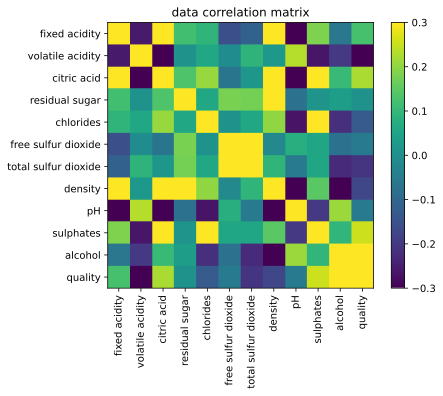

In [55]:
plt.imshow(data.corr(),vmin=-0.3,vmax=0.3)
plt.xticks(range(len(data.columns)),labels=data.columns,rotation=90)
plt.yticks(range(len(data.columns)),labels=data.columns)
plt.colorbar()
plt.title('data correlation matrix')